In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd
!pip install rank_bm25

/content


In [2]:
import os
import sys
import psutil
import nltk
import time
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.core import display as ICD
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from rank_bm25 import BM25Okapi, BM25L, BM25Plus
nltk.download('punkt')
nltk.download('wordnet')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/hacknu"
def show_memory(st):
  process = psutil.Process(os.getpid())
  print(f'Memory usage {st}:', process.memory_info().rss / 1024 / 1024, 'mb')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
show_memory('at start')

Memory usage at start: 164.4609375 mb


In [6]:
%cd "/content/drive/MyDrive/Colab Notebooks/hacknu"

/content/drive/MyDrive/Colab Notebooks/hacknu


In [8]:
!kaggle datasets download -d snapcrack/all-the-news

all-the-news.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
df = pd.read_feather('articles.f')
# df = df.head(10)
# df1 = pd.read_csv('articles1.csv')
# df2 = pd.read_csv('articles2.csv')
# df3 = pd.read_csv('articles3.csv')
# frames = [df1, df2]
# df = pd.concat(frames)
# df.set_index('id', inplace=True)

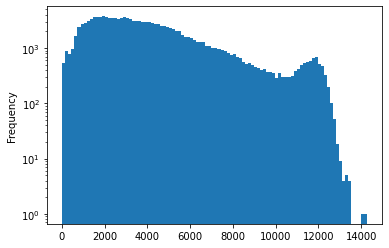

In [8]:
ax = df['content'].apply(len).plot.hist(bins=100, log=True)
# ax.set_xscale('log')

In [9]:
lemmatizer = WordNetLemmatizer()

def smart_tokenize(txt):
  tokens = nltk.word_tokenize(txt.lower())
  return tokens
  # return [lemmatizer.lemmatize(w) for w in tokens]

def tokenize_row(row):
  return smart_tokenize(row.content)

# df['content2'] = df.apply(lambda row: nltk.word_tokenize(row.content.lower()), axis=1)

In [25]:
# np.set_printoptions(threshold=sys.maxsize)
# df.reset_index().to_feather('model.f')
# df = pd.read_feather('model.f')
# df = pd.read_csv('model.csv')

In [26]:
import gc
gc.collect()

131

In [10]:
bm25 = BM25L(df['content2'])

In [11]:
vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
vectors = vectorizer.fit_transform(df.apply(lambda row: ' '.join(row.content2), axis=1))

In [51]:
def exact_match(subarr, arr):
  if len(subarr) >= 4 and ''.join(subarr) in ''.join(arr):
    return 1
  return 0

In [23]:
# queries = ['presidential election', 'olympic sport in rio', 'work desk', 'Katy Perry', 'Gennifer Flowers not attending first']
for query in [input('Enter search query:')]:
  print('query:', query)
  t1 = time.time()
  tokenized_query = smart_tokenize(query)
  doc_scores = bm25.get_scores(tokenized_query)
  result = df[['title', 'year']].copy()
  result['bm25score'] = pd.Series(doc_scores)
  tfid_query_vector = vectorizer.transform([query])
  result['cossim'] = (vectors * tfid_query_vector.T).todense()
  result['exact'] = df.content.apply(lambda x: int(''.join(tokenized_query) in x))
  result['content'] = df['content2'].apply(lambda x: ' '.join(x[:100]))
  # result.sort_values(by=['exact'], ascending=False, inplace=True)
  result.sort_values(['exact', 'bm25score'], ascending=[False, False], inplace=True)
  t2 = time.time() - t1
  ICD.display(result[['title', 'year', 'bm25score', 'cossim', 'content']].head(10))
print('elapsed:', t2, 's')

Enter search query:olympic sport
query: olympic sport


,title,year,bm25score,cossim,content
54707,Women’s Softball Needs the Olympics,2016.0,350.784315,0.310105,for u to continue writing great story we need to display ad please select the extension that is ...
132835,Documents: USOC alerted to sex abuse problems long before taking action,2017.0,343.259943,0.293662,in october 1999 the former chief executive of usa gymnastics told the u s olympic committee it h...
3370,Sports Court Upholds Ban on Russian Track and Field Athletes - The New York Times,2016.0,294.885983,0.498235,an appeal court on thursday upheld the ban on russia s track and field team from the rio olympic...
41002,The real March Madness: When will women’s teams get equal buzz?,2015.0,286.552248,0.382305,cnn last month my husband and i took our daughter to a columbia university woman s basketball ga...
139369,Doping has always been part of the Olympics. Of course Russia got off the hook.,2016.0,284.164866,0.417475,when the international olympic committee announced last weekend that it would not ban the entire...
130199,More women compete on primetime TV at the Olympics than any other point in the year,2016.0,280.720117,0.375143,every day of the olympic game in rio seems to have generated at least one cringeworthy story abo...
132424,An athlete accused her coach of sex abuse. Olympic officials stayed on the sideline.,2017.0,263.266035,0.224055,colorado spring the document describing a coach s sexual abuse of three aspiring olympic athlete...
3472,Olympic Officials Set Russia’s Roster More Than 100 Are Barred for Doping - The New York Times,2016.0,247.750550,0.504938,rio de janeiro olympic official announced on thursday night that 271 russian athlete had been ap...
1410,Clashing Agendas: Antidoping Officials vs. U.S. Olympics Leaders - The New York Times,2017.0,237.846426,0.388224,colorado spring executive at the united state agency here are agitating for a forceful response ...
3334,Russia May Face Olympics Ban as Doping Scheme Is Confirmed - The New York Times,2016.0,236.957254,0.318374,toronto the world s leading antidoping official on monday called for russia to be barred from th...


elapsed: 2.039829730987549 s


In [19]:
pd.set_option('max_colwidth', 100)

In [40]:
show_memory('at the end')

Memory usage at the end: 6606.31640625 mb
